In [1]:
pip install torch numpy matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_synthetic_trajectory(num_steps=500):
    """
    Simulates polymer motion using a simple GLE-inspired stochastic process.
    Returns a numpy array of shape (num_steps, 3) -> [position, velocity, force].
    """
    dt = 0.1
    gamma = 0.1  # Friction coefficient
    k = 1.0  # Spring constant
    noise_std = 0.05  # Noise strength

    positions = [0]
    velocities = [0]
    forces = [0]

    for t in range(1, num_steps):
        force = -k * positions[-1] + np.random.normal(0, noise_std)  # Hooke's Law + noise
        velocity = velocities[-1] * np.exp(-gamma * dt) + force * dt
        position = positions[-1] + velocity * dt

        positions.append(position)
        velocities.append(velocity)
        forces.append(force)

    trajectory = np.column_stack((positions, velocities, forces))
    return trajectory

# Generate Data
trajectory_data = generate_synthetic_trajectory(num_steps=1000)


class PolymerDataset(torch.utils.data.Dataset):
    def __init__(self, trajectory, sequence_length=10):
        """
        trajectory: numpy array of shape (timesteps, features), where features = [position, velocity, force]
        sequence_length: Number of past time steps used for prediction.
        """
        self.trajectory = trajectory
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.trajectory) - self.sequence_length

    def __getitem__(self, idx):
        x = self.trajectory[idx: idx + self.sequence_length, :]  # Past sequence
        y = self.trajectory[idx + self.sequence_length, 0]  # Predict next position
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create Dataset and DataLoader
sequence_length = 10
dataset = PolymerDataset(trajectory_data, sequence_length=sequence_length)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
class TransformerDynamics(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerDynamics, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)  # Project input to model dimension
        self.positional_encoding = nn.Parameter(torch.randn(1, 1000, hidden_dim))  # Positional encoding (large enough)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            batch_first=True  # Ensure batch_first is True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, 1)  # Predict next position

    def forward(self, x):
        """
        x: (batch_size, seq_length, input_dim)
        """
        batch_size, seq_length, _ = x.shape

        x = self.embedding(x)  # (batch_size, seq_length, hidden_dim)
        x += self.positional_encoding[:, :seq_length, :]  # Add positional encoding
        x = self.transformer(x)  # Pass through transformer
        x = self.fc_out(x[:, -1, :])  # Use only the last timestep for prediction
        return x.squeeze()

# Model Parameters
input_dim = 3  # Position, velocity, force
hidden_dim = 64
num_heads = 4
num_layers = 3
dropout = 0.1

# Instantiate Model
model = TransformerDynamics(input_dim, hidden_dim, num_heads, num_layers, dropout)


In [5]:
def train_model(model, dataloader, num_epochs=500, learning_rate=0.001, clip_value=5.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Halve LR every 20 epochs

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()

            # Gradient Clipping to prevent instability
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            total_loss += loss.item()

        scheduler.step()  # Update learning rate

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    print("Training Complete!")

# Train the Model
train_model(model, dataloader, num_epochs=500, learning_rate=0.001)

Epoch 10/500, Loss: 0.000905, LR: 0.001000
Epoch 20/500, Loss: 0.000361, LR: 0.000500
Epoch 30/500, Loss: 0.000175, LR: 0.000500
Epoch 40/500, Loss: 0.000152, LR: 0.000250
Epoch 50/500, Loss: 0.000112, LR: 0.000250
Epoch 60/500, Loss: 0.000102, LR: 0.000125
Epoch 70/500, Loss: 0.000103, LR: 0.000125
Epoch 80/500, Loss: 0.000092, LR: 0.000063
Epoch 90/500, Loss: 0.000092, LR: 0.000063
Epoch 100/500, Loss: 0.000081, LR: 0.000031
Epoch 110/500, Loss: 0.000080, LR: 0.000031
Epoch 120/500, Loss: 0.000081, LR: 0.000016
Epoch 130/500, Loss: 0.000078, LR: 0.000016
Epoch 140/500, Loss: 0.000079, LR: 0.000008
Epoch 150/500, Loss: 0.000075, LR: 0.000008
Epoch 160/500, Loss: 0.000071, LR: 0.000004
Epoch 170/500, Loss: 0.000075, LR: 0.000004
Epoch 180/500, Loss: 0.000077, LR: 0.000002
Epoch 190/500, Loss: 0.000079, LR: 0.000002
Epoch 200/500, Loss: 0.000078, LR: 0.000001
Epoch 210/500, Loss: 0.000074, LR: 0.000001
Epoch 220/500, Loss: 0.000071, LR: 0.000000
Epoch 230/500, Loss: 0.000077, LR: 0.0000

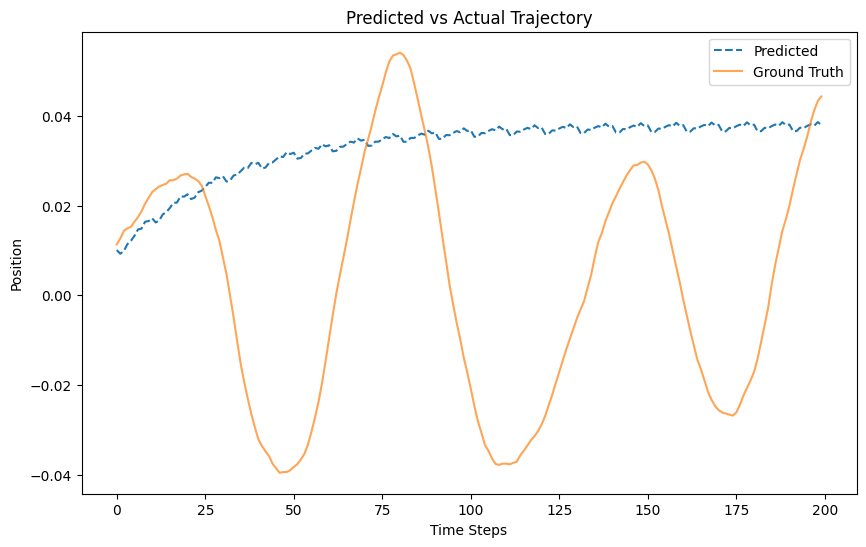

In [6]:
def predict_trajectory(model, initial_conditions, num_steps=200):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Ensure initial_conditions is a 3D tensor (batch_size, seq_len, input_dim)
    x_input = torch.tensor(initial_conditions, dtype=torch.float32).unsqueeze(0).to(device)
    predicted_positions = []

    with torch.no_grad():
        for _ in range(num_steps):
            next_pos = model(x_input).cpu().numpy()  # Predict next position
            predicted_positions.append(next_pos)

            # Update input sequence by shifting and appending the new prediction
            new_state = np.roll(x_input.cpu().numpy(), shift=-1, axis=1)
            new_state[0, -1, 0] = next_pos  # Update position
            x_input = torch.tensor(new_state, dtype=torch.float32).to(device)

    return np.array(predicted_positions).squeeze()  # Remove batch dimension

# Test Prediction
initial_conditions = trajectory_data[:sequence_length]  # First 10 time steps
predicted_positions = predict_trajectory(model, initial_conditions)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(predicted_positions, label="Predicted", linestyle="dashed")
plt.plot(trajectory_data[sequence_length:sequence_length+len(predicted_positions), 0], label="Ground Truth", alpha=0.7)
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Position")
plt.title("Predicted vs Actual Trajectory")
plt.show()